# Model Evaluation

In [8]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cpu


In [10]:
celeba_data_loc = '/home/data/celeba/'

train_dataset = CelebaDataset(celeba_data_loc + 'landmarks_train.csv', celeba_data_loc + 'attr_train.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
val_dataset = CelebaDataset(celeba_data_loc + 'landmarks_val.csv', celeba_data_loc + 'attr_val.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
test_dataset = CelebaDataset(celeba_data_loc + 'landmarks_test.csv', celeba_data_loc + 'attr_test.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

FileNotFoundError: [Errno 2] No such file or directory: '/home/data/celeba/landmarks_train.csv'

# Load Model if outputs already saved

In [13]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

ls: /Code/facial_landmark_debiasing/src/experiments/checkpoints: No such file or directory


In [ ]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2"

In [ ]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2/results.csv"
model_results = pd.read_csv(model_path)

In [ ]:
num_landmarks = 5
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

In [ ]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=20, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
img_num = 100

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()

In [ ]:
# load data and predictions
x = # input data
y = # true locations
y_hat = # predictions

n, m = [*y.shape]

In [ ]:
# define d to be either interocular distance or bounding box diagonal length
d = 

In [122]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
Z = []
alpha = 0.05
calculate_landmark = False

In [123]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m
d is the interocular distance
"""

def nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    return torch.square(torch.norm(y_hat-y, dim=1)) / d / m

def nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = torch.square(y_hat-y) / torch.unsqueeze(d, 1) 
    nme = torch.reshape(nme, (n, 2, m/2))
    return torch.mean(nme, axis=1)

def total_nme(nme):
    # Output: average NME across all images
    return torch.mean(nme)

def ced(nme):
    # Output: plot of the CED
    x = torch.sort(nme).numpy
    y = np.arange(n) / float(n)
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    x = torch.where(nme < alpha, 1, 0)
    return torch.sum(failure) / n

def fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-auc(nme, alpha)

In [124]:
nme_images = nme_images(y_hat, y, m, d)
nme_landmarks = nme_landmarks(y_hat, y, m, d)
total_nme = total_nme(nme_images)

print('Average Normalized Mean Error:', total_nme)

SyntaxError: invalid syntax (<ipython-input-124-4414bfc79562>, line 5)

In [125]:
ced = ced(nme_images)

TypeError: sort(): argument 'input' (position 1) must be Tensor, not function

In [ ]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def mmd_err(majority, minority):
    difference = torch.mean(majority, dim=0) - torch.mean(minority, dim=0)
    return difference

def mmd_fr(majority, minority, alpha):
    difference = fr(majority, alpha, dim=0) - fr(minority, alpha, dim=0)
    return difference

In [ ]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


if calculate_landmark:
    mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[tensor.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[tensor.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = mmd_err(majority, minority)
    mmd_fr[z] = mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
if calculate_landmark:
    for z, maj in Z:
        majority = nme_landmarks[tensor.where(x[:, z] == maj)] # size # images in majority x m/2
        minority = nme_landmarks[tensor.where(x[:, z] != maj)] # size # images in minority x m/2
        mmd_error_landmarks[z] = mmd_error_landmarks(majority, minority)

In [ ]:
print('MMD in Error:', mmd_error)
print('MMD in Failure Rate:', mmd_fr)

if calculate_landmark:
    print('MMD in Error per landmark')
    for z, error in mmd_error_landmarks.items():
        print(f'Landmark {z}: {error}')

# Train Model (only run once per model)

## Evaluate CelebA

In [9]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [127]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2"

model.pt  optimizer.pt  results.csv


In [16]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2/model.pt"
model = torch.load(model_path).to(device)

In [61]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=5*2, device=device)

  0%|          | 4/4991 [00:00<05:02, 16.49it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 8/4991 [00:00<05:18, 15.66it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 12/4991 [00:00<04:59, 16.61it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 14/4991 [00:00<05:14, 15.84it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 18/4991 [00:01<05:28, 15.14it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 20/4991 [00:01<05:21, 15.45it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 22/4991 [00:01<06:56, 11.94it/s]

torch.Size([4, 3, 224, 224])


  0%|          | 24/4991 [00:01<08:38,  9.57it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 28/4991 [00:02<07:58, 10.38it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 30/4991 [00:02<14:18,  5.78it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 31/4991 [00:03<08:04, 10.23it/s]

torch.Size([4, 3, 224, 224])


KeyboardInterrupt: 

In [134]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Print CelebA predictions

In [107]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=20, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


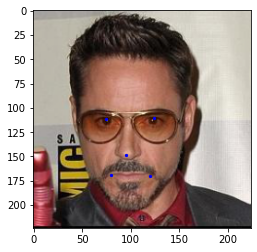

Truth


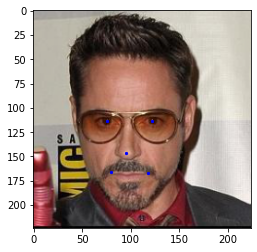

In [147]:
img_num = 2000

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()